In [24]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

        
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display, HTML
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [25]:
%pip install pywaffle



Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


<div style="background-color: skyblue; color: #1434A4; border-radius: 32px; height:50px">
    <center><h1 style="display:block; padding:7px">Importing required libraries 📚</h1></center>
</div>


In [26]:
import graphviz
import missingno as msno
from pywaffle import Waffle

from sklearn.preprocessing import RobustScaler

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier

from xgboost import XGBClassifier

from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, f1_score
import sklearn.metrics as metrics

ModuleNotFoundError: No module named 'graphviz'

<div style="background-color: skyblue; color: #1434A4; border-radius: 32px; height: 50px">
    <center><h1 style="display:block; padding:7px">Dataset Fields 🪟</h1></center>
</div>

* <strong>fixed acidity</strong>
* <strong>volatile acidity</strong>
* <strong>citric acid</strong>
* <strong>residual sugar</strong>
* <strong>chlorides</strong>
* <strong>free sulfur dioxide</strong>
* <strong>total sulfur dioxide</strong>
* <strong>density</strong>
* <strong>pH</strong>
* <strong>sulphates</strong>
* <strong>alcohol</strong>

Output variable (based on sensory data):
* <strong>quality (score between 0 and 10)</strong>

<div style="background-color: skyblue; color: #1434A4; border-radius: 32px; height: 50px">
    <center><h1 style="display:block; padding:7px">Setting up Color Palette 🎨</h1></center>
</div>


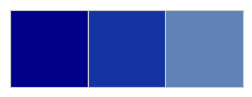

In [ ]:
colors = ['#00008B', '#1434A4', '#6082B6']
palette = sns.set_palette(sns.color_palette(colors))
sns.palplot(sns.color_palette(colors), size=1)
plt.tick_params(axis='both')

<div style="background-color: skyblue; color: #1434A4; border-radius: 32px; height: 50px">
    <center><h1 style="display:block; padding:7px">Checking up the dataset 🗸</h1></center>
</div>


#### Reading the dataset

In [ ]:
df = pd.read_csv('../Data/WineQT.csv')

FileNotFoundError: [Errno 2] No such file or directory: '../input/wine-quality-dataset/WineQT.csv'

In [ ]:
df

In [ ]:
df.info()

#### Checking null values

In [ ]:
pd.DataFrame({'Missing Values': df.isna().sum()})

#### Statistical summary of the dataset

In [ ]:
df.describe()

<div style="background-color: skyblue; color: #1434A4; border-radius: 32px; height: 50px">
    <center><h1 style="display:block; padding:7px">Dataset EDA 📊</h1></center>
</div>


#### Checking the Wine Quality distribution

In [ ]:
quality = df['quality'].value_counts()

fig = plt.figure(
    FigureClass = Waffle, 
    rows = 4,
    columns = 8,
    values = quality,
    labels = ['{} - {}'.format(a, b) for a, b in zip(quality.index, quality)],
    legend = {
        'loc': 'upper left', 
        'bbox_to_anchor': (1, 1), 
        'fontsize': 20, 
        'labelcolor': 'linecolor',
        'title': 'Wine Quality',
        'title_fontsize': 20
        },
    font_size = 60, 
    icon_legend = True,
    figsize = (10, 8)
)

plt.title('Wine Quality Distribution', fontsize = 20)
plt.show()

In [ ]:
def feature_viz(feature):
    plt.figure(figsize=(15,8))
    plt.title(f'{feature} hist plot')
    plt.subplot(1,3,1)
    df[feature].plot(kind='hist')

    plt.subplot(1,3,2)
    plt.title(f'{feature} box plot')
    sns.boxplot(df[feature])
    
    plt.subplot(1, 3, 3)
    plt.title(f'{feature} density plot')
    sns.kdeplot(df[feature])
    plt.tight_layout()

#### Checking whether the distribution is normal and checking the number of outliers

In [ ]:
for i in df.columns:
    feature_viz(i)

##### As there are extreme outliers in some features, I'll use RobustScaler and log transformation for normalizing them.

# Checking the correlation plot

In [ ]:
mask = np.zeros_like(df.drop('Id', axis=1).corr())
tri_ind = np.triu_indices_from(mask)
mask[tri_ind] = True
plt.figure(figsize=[15, 10])
sns.heatmap(data=df.drop('Id', axis=1).corr(), annot=True, mask=mask, cmap='Blues', square=True)

# Correlation with Target feature

In [ ]:
plt.figure(figsize=(14,6))
corr = df.corr()['quality'].sort_values(ascending=False)
corr.drop('quality').plot(kind='bar')

##### I'll drop 'quality','free sulfur dioxide', 'pH', 'residual sugar' as they have low correlation and take log transformation of remaining features.

In [ ]:
x = np.log1p(df.drop(['quality','free sulfur dioxide', 'pH', 'residual sugar'], axis=1))
y = df['quality']

<div style="background-color: skyblue; color: #1434A4; border-radius: 32px; height: 50px">
    <center><h1 style="display:block; padding:7px">Splitting the data 🪓</h1></center>
</div>


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=101)

In [ ]:
rs = RobustScaler()
x_train = rs.fit_transform(x_train)
x_test = rs.transform(x_test)

<div style="background-color: skyblue; color: #1434A4; border-radius: 32px; height: 50px">
    <center><h1 style="display:block; padding:7px">Performing the training and testing session 🧪</h1></center>
</div>


# Logistic Regression

In [ ]:
lr = LogisticRegression()
lr.fit(x_train, y_train)
lr_pred = lr.predict(x_test)
lr_acc = lr.score(x_test, y_test)
print("Training accuracy for Logistic Regression: ", lr.score(x_train, y_train)*100, "%")
print("Testing accuracy for Logistic Regression:", lr_acc*100, "%")

# K-Nearest Neighbors

In [ ]:
knn = KNeighborsClassifier()
knn.fit(x_train, y_train)
knn_pred = knn.predict(x_test)
knn_acc = knn.score(x_test, y_test)
print("The training accuracy for KNN is:", knn.score(x_train, y_train)*100, "%")
print("The testing accuracy for KNN is:", knn_acc * 100, "%")

# SVC

In [ ]:
svc = SVC()
svc.fit(x_train, y_train)
svc_pred = svc.predict(x_test)
svc_acc = svc.score(x_test, y_test)
print("The training accuracy for SVC is:", svc.score(x_train, y_train)*100, "%")
print("The testing accuracy for SVC is:", svc_acc * 100, "%")

# Decision Tree Classifier

In [ ]:
dtc = DecisionTreeClassifier()
dtc.fit(x_train, y_train)
dtc_pred = dtc.predict(x_test)
dtc_acc = dtc.score(x_test, y_test)
print("The training accuracy for decision tree classifier is:", dtc.score(x_train, y_train)*100, "%")
print("The testing accuracy for decision tree classifier is:", dtc_acc * 100, "%")

# Visualizing the Decision Tree graph

In [ ]:
dot_data = tree.export_graphviz(dtc, out_file = None, feature_names = df.drop(['quality','free sulfur dioxide', 'pH', 'residual sugar'], axis=1).columns, class_names = ["3", "4", "5", "6", "7", "8"], filled = True)
graph = graphviz.Source(dot_data, format = "jpg")
display(graph)

# Random Forest

In [ ]:
rfc = RandomForestClassifier()
rfc.fit(x_train, y_train)
rfc_pred = rfc.predict(x_test)
rfc_acc = rfc.score(x_test, y_test)
print("The training accuracy for Random Forest is:", rfc.score(x_train, y_train)*100, "%")
print("The testing accuracy for Random Forest is:", rfc_acc * 100, "%")

# Adaboost

In [ ]:
abc = AdaBoostClassifier()
abc.fit(x_train, y_train)
abc_pred = abc.predict(x_test)
abc_acc = abc.score(x_test, y_test)
print("The training accuracy for AdaBoost is:", abc.score(x_train, y_train)*100, "%")
print("The testing accuracy for AdaBoost is:", abc_acc * 100, "%")

# Extra Trees Classifier

In [ ]:
etc = ExtraTreesClassifier()
etc.fit(x_train, y_train)
etc_pred = etc.predict(x_test)
etc_acc = etc.score(x_test, y_test)
print("The training accuracy for Extra Trees Classifier is:", etc.score(x_train, y_train)*100, "%")
print("The testing accuracy for Extra Trees Classifier is:", etc_acc * 100, "%")

# Bagging Classifier

In [ ]:
bc = BaggingClassifier()
bc.fit(x_train, y_train)
bc_pred = bc.predict(x_test)
bc_acc = bc.score(x_test, y_test)
print("The training accuracy for bagging classifier is:", bc.score(x_train, y_train)*100, "%")
print("The testing accuracy for bagging classifier is:", bc_acc * 100, "%")

# Gradient Boosting Classifier

In [ ]:
gbc = GradientBoostingClassifier()
gbc.fit(x_train, y_train)
gbc_pred = gbc.predict(x_test)
gbc_acc = gbc.score(x_test, y_test)
print("The training accuracy for gradient boosting classifier is:", gbc.score(x_train, y_train)*100, "%")
print("The testing accuracy for gradient boosting classifer is:", gbc_acc * 100, "%")

# XGBoost Classifier

In [ ]:
xgb = XGBClassifier(verbosity=0)
xgb.fit(x_train, y_train)
xgb_pred = xgb.predict(x_test)
xgb_acc = xgb.score(x_test, y_test)
print("The training accuracy for XGB is:", xgb.score(x_train, y_train)*100, "%")
print("The testing accuracy for XGB is:", xgb_acc * 100, "%")

# Catboost Classifier

In [ ]:
cbc = CatBoostClassifier(verbose=0)
cbc.fit(x_train, y_train)
cbc_pred = cbc.predict(x_test)
cbc_acc = cbc.score(x_test, y_test)
print("The training accuracy for CatBoost Classifer is:", cbc.score(x_train, y_train)*100, "%")
print("The testing accuracy for CatBoost Classifier is:", cbc_acc * 100, "%")

<div style="background-color: skyblue; color: #1434A4; border-radius: 32px; height: 50px">
    <center><h1 style="display:block; padding:7px">Models Summary 📝</h1></center>
</div>


In [ ]:
models = {'Logistic': lr_acc, 'KNN': knn_acc, 'SVC': svc_acc, 'Decision Tree': dtc_acc, 'Random Forest': rfc_acc, 
         'AdaBoost': abc_acc, 'Extra Trees': etc_acc, 'Bagging': bc_acc, 'Gradient Boosting': gbc_acc, 
         'XGB': xgb_acc, 'Catboost': cbc_acc}
models_df = pd.DataFrame(pd.Series(models))
models_df.columns = ['Scores']
models_df['Name'] = ['Logistic', 'KNN', 'SVC', 'Decision Tree', 'Random Forest', 
         'AdaBoost', 'Extra Trees', 'Bagging', 'Gradient Boosting', 
         'XGB', 'Catboost']
models_df.set_index(pd.Index([1, 2, 3 , 4, 5 , 6, 7, 8, 9, 10, 11]))

In [ ]:
plt.figure(figsize=[15, 10])
axis = sns.barplot(x = 'Name', y = 'Scores', data = models_df)
axis.set(xlabel='Classifier', ylabel='Accuracy')
for p in axis.patches:
    height = p.get_height()
    axis.text(p.get_x() + p.get_width()/2, height + 0.005, '{:1.4f}'.format(height), ha="center") 

<div style="background-color: skyblue; color: #1434A4; border-radius: 32px; height: 50px">
    <center><h1 style="display:block; padding:7px">I hope you like this!✌️</h1></center>
</div>
